# Dec 2, 2024: model comparison
using `total evidence, L` of a model per chain

In [1]:
import csv
import os
import sys
import numpy as np
import pandas as pd
import scipy as sp 
import dill as pickle 
from os.path import join as pjoin
from itertools import product
from tqdm import tqdm
from copy import deepcopy
from pathlib import Path
import subprocess
from scipy import sparse, stats
from statsmodels.stats.multitest import multipletests
from multiprocessing import Pool
import glob
import random

import arviz as az

from itertools import product, combinations
import multiprocessing as mp
from functools import partial

# networks
import graph_tool.all as gt

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow
from matplotlib.patches import Rectangle

plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import cmasher as cmr  # CITE ITS PAPER IN YOUR MANUSCRIPT
import colorcet as cc

# ignore user warnings
import warnings
warnings.filterwarnings("ignore") #, category=UserWarning)

In [2]:
class ARGS():
    pass

args = ARGS()

args.SEED = 100

def set_seed(args):
    gt.seed_rng(args.SEED)
    np.random.seed(args.SEED)

set_seed(args)

In [3]:
args.type = 'spatial'
args.roi_size = 225
args.maintain_symmetry = True
args.brain_div = 'whl'
args.num_rois = 162

PARC_DESC = (
    f'type-{args.type}'
    f'_size-{args.roi_size}'
    f'_symm-{args.maintain_symmetry}'
    f'_braindiv-{args.brain_div}'
    f'_nrois-{args.num_rois}'
)

In [4]:
args.GRAPH_DEF = f'constructed'
args.GRAPH_METHOD = f'pearson-corr'
args.THRESHOLDING = f'positive'
args.EDGE_DEF = f'binary'
args.EDGE_DENSITY = 20
args.LAYER_DEF = f'individual'
args.DATA_UNIT = f'sub'

BASE_path = f'{os.environ["HOME"]}/mouse_dataset/roi_results_v2'
ROI_path = f'{BASE_path}/{PARC_DESC}'
TS_path = f'{ROI_path}/runwise_timeseries'
ROI_RESULTS_path = (
    f'{ROI_path}'
    f'/graph-{args.GRAPH_DEF}/method-{args.GRAPH_METHOD}'
    f'/threshold-{args.THRESHOLDING}/edge-{args.EDGE_DEF}/density-{args.EDGE_DENSITY}'
    f'/layer-{args.LAYER_DEF}/unit-{args.DATA_UNIT}'
)
GRAPH_path = f'{ROI_RESULTS_path}/graphs'
os.system(f'mkdir -p {GRAPH_path}')
SBM_path = f'{ROI_RESULTS_path}/model-fits'
os.system(f'mkdir -p {SBM_path}')
ESTIM_path = f'{ROI_RESULTS_path}/estimates'
os.system(f'mkdir -p {ESTIM_path}/individual')
os.system(f'mkdir -p {ESTIM_path}/group')

0

In [5]:
main_folders = sorted(glob.glob(f'{SBM_path}/*', recursive=True))
main_folders

['/home/govindas/mouse_dataset/roi_results_v2/type-spatial_size-225_symm-True_braindiv-whl_nrois-162/graph-constructed/method-pearson-corr/threshold-positive/edge-binary/density-20/layer-individual/unit-sub/model-fits/sub-SLC01',
 '/home/govindas/mouse_dataset/roi_results_v2/type-spatial_size-225_symm-True_braindiv-whl_nrois-162/graph-constructed/method-pearson-corr/threshold-positive/edge-binary/density-20/layer-individual/unit-sub/model-fits/sub-SLC02',
 '/home/govindas/mouse_dataset/roi_results_v2/type-spatial_size-225_symm-True_braindiv-whl_nrois-162/graph-constructed/method-pearson-corr/threshold-positive/edge-binary/density-20/layer-individual/unit-sub/model-fits/sub-SLC03',
 '/home/govindas/mouse_dataset/roi_results_v2/type-spatial_size-225_symm-True_braindiv-whl_nrois-162/graph-constructed/method-pearson-corr/threshold-positive/edge-binary/density-20/layer-individual/unit-sub/model-fits/sub-SLC04',
 '/home/govindas/mouse_dataset/roi_results_v2/type-spatial_size-225_symm-True_br

In [6]:
def collect_evidences_per_sub(args, evidence_files):
    ldf = []
    for file in evidence_files:
        with open(f'{file}', 'rb') as f:
            [L] = pickle.load(f)
        sub = [s for s in file.split('/') if 'sub-' in s][0].split('-')[-1]
        sbm = '-'.join([s for s in file.split('/') if 'sbm-' in s][0].split('-')[1:])
        B = [s for s in file.split('/') if 'B-' in s][0].split('-')[-1]
        if sbm in ['-a', '-m']: continue
        row = pd.DataFrame(dict(
            sbm=[sbm],
            B=[B],
            L=[L],
        ))
        ldf += [row]
    ldf = pd.concat(ldf).reset_index(drop=True)
    pdf = ldf.pivot(index='B', columns='sbm', values='L')
    
    return sub, ldf, pdf

def sort_sbms(pdf):
    cols = list(pdf.columns)
    sorted_cols = stats.mode(pdf.fillna(-np.inf).apply(np.argsort, axis=1).to_numpy()).mode
    sorted_cols = [cols[i] for i in sorted_cols]
    pdf = pd.DataFrame(
        data=pdf, 
        columns=sorted_cols,
    )
    return pdf

In [7]:
def compare_columns_ttest(df):
    results = {}
    for col1, col2 in combinations(df.columns, 2):
        # Drop rows where either column has NaN
        mask = df[[col1, col2]].notna().all(axis=1)
        if mask.sum() > 1:  # need at least 2 pairs
            stat, pval = stats.ttest_rel(df[col1][mask], df[col2][mask])
            results[(col1, col2)] = {'t-stat': stat, 'p-value': pval}
    comps_df = pd.DataFrame(results).T
    # Benjamini-Hochberg: Controls FDR
    comps_df['p-value-corr'] = multipletests(comps_df['p-value'], method='fdr_bh')[1]
    return comps_df

In [8]:
def get_significance_star(p_val):
    if p_val < 0.001:
        star = '***'
    elif p_val < 0.01:
        star = '**'
    elif p_val < 0.05:
        star = '*'
    else:
        star = ''
    return star

def plot_model_comparisons(sub, pdf, comps_df,):  
    cols = list(pdf.columns)
    col_pairs = list(zip(cols, cols[1:]))

    fig, axs = plt.subplots(1, 1, figsize=(10, 5))
    ax = axs

    for idx, row in pdf.iterrows():
        # plot the points
        ax.scatter(range(len(row)), row.values, s=25, c='cornflowerblue', alpha=1.0, marker='.', linewidths=8,)
        # connect the points
        ax.plot(range(len(row)), row.values, linestyle='-', linewidth=1, c='grey', alpha=0.5)
    
    title = f'sub-{sub}' if 'SLC' in sub.split('-') else f'group comparisons'
    ax.set(
            title=title,
            ylabel='total evidence, log $P(A | M)$', 
            xlabel='model class, $M$',
        )
    ax.set_xticks(range(len(pdf.columns)), pdf.columns, rotation=0)
    ax.grid(alpha=0.3)


    x = range(len(cols))
    for idx, col_pair in enumerate(col_pairs):
        try:
            star = get_significance_star(comps_df.loc[col_pair]['p-value-corr'])
        except:
            star = ''
        
        y_min, y_max = pdf.max().max(), pdf.min().min()
        delta = y_max - y_min
        height = y_max + 0.05*delta
        ax.text(x[idx]+0.5, height-delta*1.0, f'{star}', ha='center', va='bottom')
    return fig

In [9]:
for sub_folder in main_folders[:]:
    evidence_files = sorted(glob.glob(f'{sub_folder}/sbm-*/B-*/desc-evidence.pkl', recursive=True))
    sub, ldf, pdf = collect_evidences_per_sub(args, evidence_files)
    pdf = sort_sbms(pdf)
    comps_df = compare_columns_ttest(pdf)
    fig = plot_model_comparisons(sub, pdf, comps_df)

    out_folder = f'{ESTIM_path}/individual/sub-{sub}/model-comparison'
    os.system(f'mkdir -p {out_folder}')

    with open(f'{out_folder}/desc-evidences.pkl', 'wb') as f:
        pickle.dump(pdf, f)

    with open(f'{out_folder}/desc-comparisons.pkl', 'wb') as f:
        pickle.dump(comps_df, f)

    fig.savefig(f'{out_folder}/desc-plot.pdf', bbox_inches='tight')

    plt.close('all')
    # display(pdf)
    # display(comps_df)

group level aggregation

In [38]:
main_df = []
for sub_folder in main_folders[:]:
    evidence_files = sorted(glob.glob(f'{sub_folder}/sbm-*/B-*/desc-evidence.pkl', recursive=True))
    sub, ldf, pdf = collect_evidences_per_sub(args, evidence_files)
    cols = list(pdf.mean().index)
    vals = np.array(list(pdf.mean()))[None, :]
    row = pd.DataFrame(data=vals, columns=cols)
    main_df += [row]
main_df = pd.concat(main_df).reset_index(drop=True)

In [11]:
# main_df = sort_sbms(main_df)

In [39]:
main_df

,dc-d,dc-h,nd-d,nd-h
0,-5522.340441,-5443.354310,-5404.183855,-5306.534271
1,-5323.480504,-5258.568425,-5238.068526,-5122.990489
2,-5367.970963,-5290.783591,-5294.919173,-5196.475097
3,-5500.558615,-5416.514665,-5373.412440,-5290.529993
4,-5242.644278,-5146.465292,-5150.471576,-5044.895151
5,-5329.738632,-5235.498867,-5222.005946,-5091.865714
6,-5220.235476,-5110.829524,-5114.077525,-4988.332829
7,-5190.716592,-5076.782509,-5105.112753,-4965.053570
8,-5220.866199,-5124.463623,-5109.704137,-5002.686450
9,-5113.399644,-5003.412292,-5015.567064,-4881.128134


In [40]:
comps_df = compare_columns_ttest(main_df)
comps_df

t-stat       p-value  p-value-corr
dc-d dc-h -18.175264  2.107553e-08  2.529063e-08
     nd-d -19.060921  1.387056e-08  2.080584e-08
     nd-h -33.627665  8.964282e-11  5.378569e-10
dc-h nd-d  -1.109551  2.959580e-01  2.959580e-01
     nd-h -24.731050  1.385901e-09  4.157704e-09
nd-d nd-h -19.395964  1.189758e-08  2.080584e-08

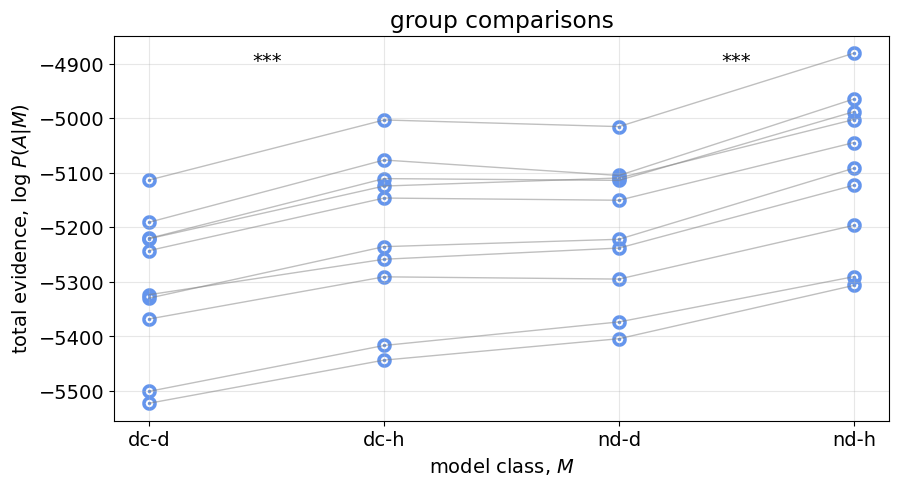

In [42]:
fig = plot_model_comparisons('none-', main_df, comps_df)